#xml to csv dataset conversion


In [0]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[5][0].text),
                     int(member[5][1].text),
                     int(member[5][2].text),
                     int(member[5][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    for folder in ['test', 'train']:
        image_path = os.path.join(os.getcwd(), ('/content/drive/My Drive/' + folder))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv(('/content/drive/My Drive/'+folder+'_labels.csv'), index=None)
    print('Successfully converted xml to csv.')


main()

In [0]:
import pandas
df = pandas.read_csv('/content/drive/My Drive/train_labels.csv')
df['class'].unique()

array(['with_mask', 'without_mask', 'mask_weared_incorrect'], dtype=object)

In [0]:
df

filename  width  height      class  xmin  ymin  xmax  ymax
0     maksssksksss687.png    301     400  with_mask    57   211   168   353
1     maksssksksss598.png    301     400  with_mask   111   203   221   355
2     maksssksksss222.png    400     226  with_mask    24    50    44    71
3     maksssksksss222.png    400     226  with_mask    59    63    77    83
4     maksssksksss222.png    400     226  with_mask   129    56   152    79
...                   ...    ...     ...        ...   ...   ...   ...   ...
3044   maksssksksss13.png    400     226  with_mask   293    60   313    81
3045   maksssksksss13.png    400     226  with_mask   352    53   373    71
3046   maksssksksss13.png    400     226  with_mask   229    53   241    72
3047  maksssksksss141.png    400     267  with_mask   129    96   175   155
3048  maksssksksss141.png    400     267  with_mask   220   123   260   169

[3049 rows x 8 columns]

#installing dependencies

In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=521789ed2de97ea7885636027d5097d770c885e7be31ee075aa43231096881d5
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-m4al407f
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-m4al407f
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [3]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 886kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200616-cp36-none-any.whl size=41027 sha256=b1ad9b681c207a8e67e63eab331a2176f8e05303f6f958c9e18afa6461144cb9
  Stored in directory: /root/.cache/pip/wheels/41/d8/fa/3ce58db3bff39667182416191bb442b206af1dbd9a5d0804cb
Successfully built fvcore


#importing dependencies

In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

#Registering dataset

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_mask_detection_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

for d in ["train", "test"]:
  DatasetCatalog.register('Mask_Detection1/' + d, lambda d=d: get_mask_detection_dicts('/content/drive/My Drive/' + d + '_labels.csv', '/content/drive/My Drive/' + d+'/'))
  MetadataCatalog.get('Mask_Detection1/' + d).set(thing_classes=classes)
maskdetector_metadata = MetadataCatalog.get('Mask_Detection1/train')


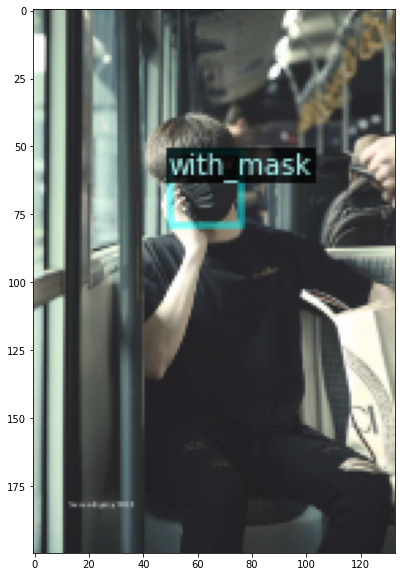

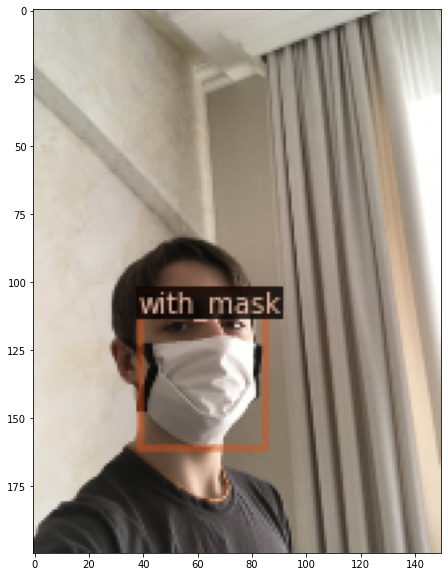

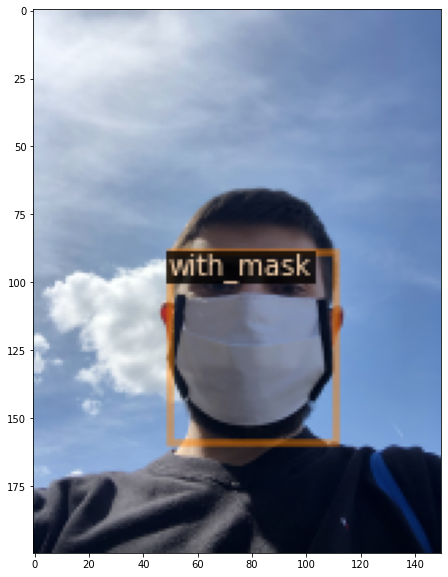

In [38]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('Mask_Detection1/train')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=maskdetector_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

#Train Model

In [28]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('Mask_Detection1/train',)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/16 12:09:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:31, 13.2MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model!


[06/16 12:10:49 d2.engine.train_loop]: Starting training from iteration 0
[06/16 12:12:06 d2.utils.events]:  eta: 1:03:26  iter: 19  total_loss: 1.898  loss_cls: 1.522  loss_box_reg: 0.086  loss_rpn_cls: 0.245  loss_rpn_loc: 0.038  time: 3.8363  data_time: 0.0218  lr: 0.000020  max_mem: 6449M
[06/16 12:13:22 d2.utils.events]:  eta: 1:01:42  iter: 39  total_loss: 1.467  loss_cls: 1.171  loss_box_reg: 0.114  loss_rpn_cls: 0.133  loss_rpn_loc: 0.031  time: 3.8125  data_time: 0.0087  lr: 0.000040  max_mem: 6650M
[06/16 12:14:36 d2.utils.events]:  eta: 1:00:09  iter: 59  total_loss: 0.839  loss_cls: 0.648  loss_box_reg: 0.132  loss_rpn_cls: 0.083  loss_rpn_loc: 0.015  time: 3.7781  data_time: 0.0083  lr: 0.000060  max_mem: 6650M
[06/16 12:15:53 d2.utils.events]:  eta: 0:59:26  iter: 79  total_loss: 0.935  loss_cls: 0.455  loss_box_reg: 0.251  loss_rpn_cls: 0.122  loss_rpn_loc: 0.034  time: 3.7919  data_time: 0.0090  lr: 0.000080  max_mem: 6650M
[06/16 12:17:12 d2.utils.events]:  eta: 0:58:1

In [29]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.DATASETS.TEST = ("Mask_Detection/test", )
predictor = DefaultPredictor(cfg)

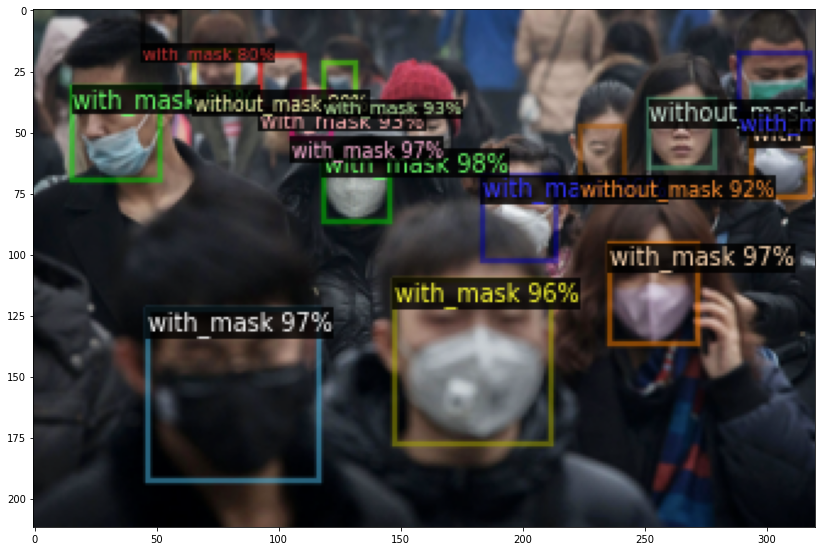

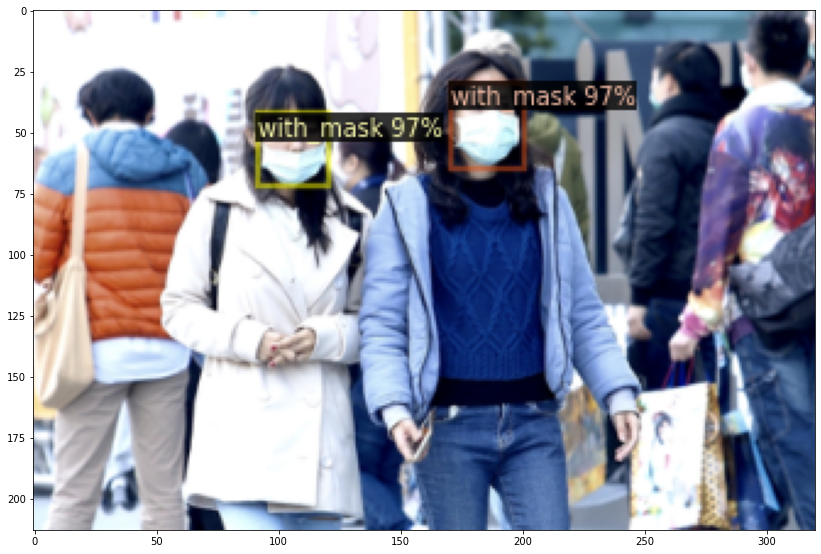

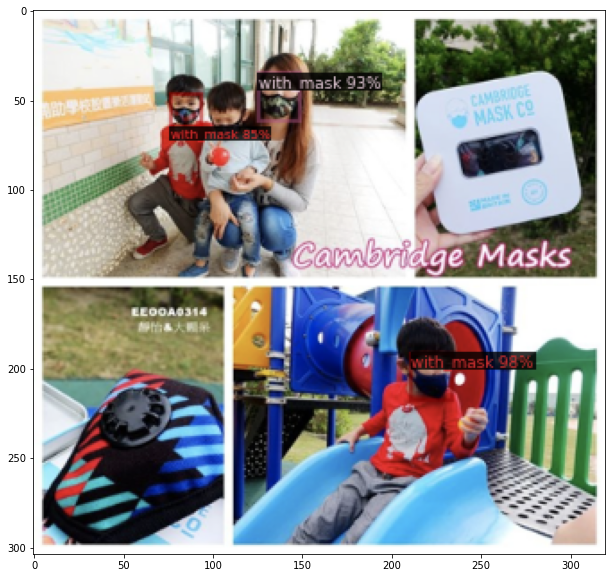

In [31]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('Mask_Detection1/test')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=maskdetector_metadata, 
                   scale=0.8 )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()